# Models

Build models to see how much each feature contributes to productivity

- Models
    - LinearRegression
    - ExplainableBoostingRegressor
- Features
    - Education
    - Population
    - R&D Expenditure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/interim/dataset.csv')
df.head()

,year,GEO,Compensation of employees per hour worked (Euro),Compensation per employee (Euro),education,population,rd_expenditure
0,2010,Belgium,34.3,49054.8,48.457143,10839905,2.06
1,2011,Belgium,35.1,50593.5,47.857143,11000638,2.17
2,2012,Belgium,36.2,52178.2,48.242857,11075889,2.28
3,2013,Belgium,37.2,53452.5,49.242857,11137974,2.33
4,2014,Belgium,37.6,53965.2,50.285714,11180840,2.37


## Scale Features

In [3]:
scaler = StandardScaler()
df['per_hour_worked'] = scaler.fit_transform(df[['Compensation of employees per hour worked (Euro)']])
df['per_employee'] = scaler.fit_transform(df[['Compensation per employee (Euro)']])
df['education'] = scaler.fit_transform(df[['education']])
df['population'] = scaler.fit_transform(df[['population']])
df['rd_expenditure'] = scaler.fit_transform(df[['rd_expenditure']])
df = df.dropna()
df[['per_hour_worked', 'per_employee', 'education', 'population', 'rd_expenditure']].corr()

,per_hour_worked,per_employee,education,population,rd_expenditure
per_hour_worked,1.000000,0.990948,0.307323,0.112138,0.580168
per_employee,0.990948,1.000000,0.260538,0.084187,0.552179
education,0.307323,0.260538,1.000000,-0.058253,0.443450
population,0.112138,0.084187,-0.058253,1.000000,0.164592
rd_expenditure,0.580168,0.552179,0.443450,0.164592,1.000000


## LinearRegression

$$
y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$

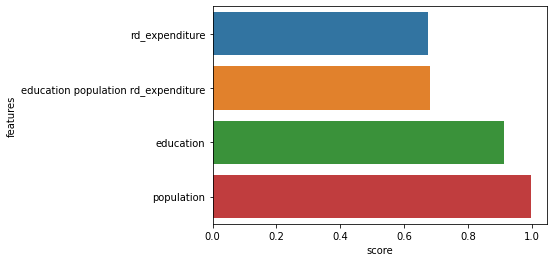

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def train(features):
    x = df[features]
    y = df[['per_hour_worked']]
    score_on_train = []
    score_on_test = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = LinearRegression()
        model.fit(x_train, y_train)
        score_on_train.append(mean_squared_error(y_train, model.predict(x_train)))
        score_on_test.append(mean_squared_error(y_test, model.predict(x_test)))

    return np.mean(score_on_test)

features = [
    ['education'],
    ['population'],
    ['rd_expenditure'],
    ['education', 'population', 'rd_expenditure']
]
scores = [train(f) for f in features]
result = pd.DataFrame({
    'features': [' '.join(f) for f in features],
    'score': scores
}).sort_values(by='score')
sns.barplot(data=result, x='score', y='features')

['education', 'education_lag_1', 'education_lag_2', 'education_lag_3', 'per_hour_worked', 'per_hour_worked_lag_1', 'per_hour_worked_lag_2', 'per_hour_worked_lag_3', 'population', 'population_lag_1', 'population_lag_2', 'population_lag_3', 'rd_expenditure', 'rd_expenditure_lag_1', 'rd_expenditure_lag_2', 'rd_expenditure_lag_3']
[[-4.99600361e-16  6.89739722e-17  2.49385214e-16  1.52240699e-16
   2.50000000e-01  2.50000000e-01  2.50000000e-01  2.50000000e-01
   3.72300129e-15  3.72300129e-15  3.72300129e-15  3.72300129e-15
  -1.47710462e-16 -1.47710462e-16 -1.47710462e-16 -1.47710462e-16]]


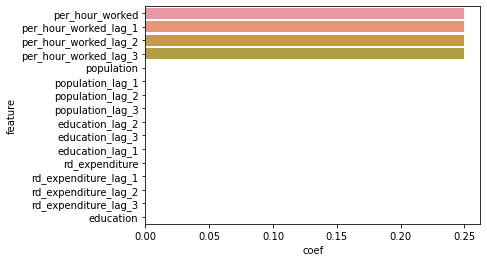

In [5]:
def add_lagged_features(df, index_columns=['year', 'GEO']):
    columns_to_rename = list(df.columns.difference(index_columns))
    shift_range = [1, 2, 3]
    for year_shift in shift_range:
        train_shift = df[index_columns + columns_to_rename].copy()
        columns = lambda x: f'{x}_lag_{year_shift}' if x in columns_to_rename else x
        train_shift.rename(columns=columns, inplace=True)
        df = df.merge(train_shift, on=['year', 'GEO'], how='left').fillna(0)
    df = df[df['year'] >= 2013]
    return df

data = add_lagged_features(df[[
    'year', 'GEO', 'per_hour_worked', 'education', 'population', 'rd_expenditure'
]]).head()

features = list(data.columns.difference(['year', 'GEO']))
x = data[features]
y = data[['per_hour_worked']]

model = LinearRegression()
model.fit(x, y)

print(features)
print(model.coef_)

result = pd.DataFrame({
    'feature': features,
    'coef': model.coef_[0]
}).sort_values(by=['coef'], ascending=False)
sns.barplot(data=result, y='feature', x='coef')

## Visualize Feature Importance

['education', 'population', 'rd_expenditure']
[[0.06637092 0.02533453 0.55678467]]


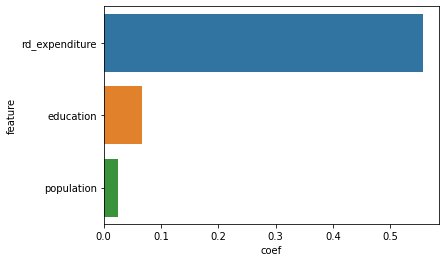

In [6]:
features = ['education', 'population', 'rd_expenditure']
x = df[features]
y = df[['per_hour_worked']]

model = LinearRegression()
model.fit(x, y)

print(features)
print(model.coef_)

result = pd.DataFrame({
    'feature': features,
    'coef': model.coef_[0]
}).sort_values(by=['coef'], ascending=False)
sns.barplot(data=result, y='feature', x='coef')

## ExplainableBoostingRegressor (from InterpretML)

EBM is a generalized additive model formalized as follows.

$$
g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ij}(x_i,x_j)
$$

EBM learns the best feature function $f_j$ for each feature to show how each feature contributes to the model's prediction for the problem. EBM can also automatically detect and include pairwise interaction terms.

Paper: https://arxiv.org/pdf/1909.09223.pdf

### Global Explanation

In [7]:
from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(x_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
interpret.show(ebm_global)

<!-- http://127.0.0.1:7017/5017209616/ -->

### Local Explanation

In [8]:
ebm_local = ebm.explain_local(x_test[:5], y_test[:5], name='EBM')
interpret.show(ebm_local)

<!-- http://127.0.0.1:7017/5018797264/ -->

In [11]:
from interpret.glassbox import LinearRegression
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(x_test, y_test, name='Linear Regression')
interpret.show(ebm_perf)

<!-- http://127.0.0.1:7017/5104352912/ -->